In [1]:
# Imports
import sys

sys.path.insert(0, "../src")
from main import load_database

import audeer

import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import yaml

import pandas as pd
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests

Fetched the DataFrames from the Pipeline after filtering etc.

```
# Convert the MultiIndex to a DataFrame
df_files = self.df_files_filtered
df_features = self.df_features_filtered

# Write the DataFrame to a CSV file - filtered and denoised
df_files.to_csv(os.path.join("notebooks/data/feature_analysis", "df_files-filtered_denoised.csv"), index=True)
df_features.to_csv(os.path.join("notebooks/data/feature_analysis", "df_features-filtered_denoised.csv"), index=True)

# Write the DataFrame to a CSV file - unfiltered and not denoised
df_files.to_csv(os.path.join("notebooks/data/feature_analysis", "df_files-not_filtered_not_denoised.csv"), index=True)
df_features.to_csv(os.path.join("notebooks/data/feature_analysis", "df_features-not_filtered_not_denoised.csv"), index=True)
```

Also have to save idx_train and idx_test (as done in bootstrapping-investigate_test_speakers.ipynb)

```
# Convert the MultiIndex to a DataFrame
df_idx_train = self.idx_train.to_frame(index=False)
df_idx_test = self.idx_test.to_frame(index=False)

# Write the DataFrame to a CSV file - filtered and denoised
df_idx_train.to_csv(os.path.join("notebooks/data/index_to_verify_split", "idx_train-filtered_denoised.csv"), index=False)
df_idx_test.to_csv(os.path.join("notebooks/data/index_to_verify_split", "idx_test-filtered_denoised.csv"), index=False)

# Write the DataFrame to a CSV file - unfiltered and not denoised
df_idx_train.to_csv(os.path.join("notebooks/data/index_to_verify_split", "idx_train-not_filtered_not_denoised.csv"), index=False)
df_idx_test.to_csv(os.path.join("notebooks/data/index_to_verify_split", "idx_test-not_filtered_not_denoised.csv"), index=False)
```

In [2]:
def fix_indices(df):
    # Convert the indices to the timedelta format
    # Labels DataFrame
    df["file"] = df["file"].astype(str)
    df["start"] = df["start"].apply(pd.to_timedelta)
    df["end"] = df["end"].apply(pd.to_timedelta)
    # Restore the MultiIndex
    df.set_index(["file", "start", "end"], inplace=True)
    return df

In [3]:
def perform_correlation_analysis(
    df_files,
    df_features,
    speech_tasks=None,
    multiple_testing="fdr_bh",
    save=True,
    condition_suffix="",
):
    # Filter the data by the speech task
    if speech_tasks:
        df_files = df_files[df_files["prompt"].isin(speech_tasks)]
        df_features = df_features.loc[df_files.index]
        speech_tasks_str = "-".join(speech_tasks)
    else:
        speech_tasks = "all_tasks"

    # Initialize a list to hold the correlation results
    correlation_results = []

    # Loop over each feature column
    for column in df_features.columns:
        # Calculate the Spearman's rank correlation coefficient
        correlation_spearman, p_value_spearman = spearmanr(
            df_features[column], df_files["stress_current"]
        )

        # Calculate the Pearson product-moment correlation coefficient
        correlation_pearson, p_value_pearson = pearsonr(
            df_features[column], df_files["stress_current"]
        )

        # Append the correlations and p-values to the list
        correlation_results.append(
            {
                "Feature": column,
                "Spearman Correlation": correlation_spearman,
                "Spearman P-Value": p_value_spearman,
                "Spearman R-Squared": correlation_spearman**2,
                "Pearson Correlation": correlation_pearson,
                "Pearson P-Value": p_value_pearson,
                "Pearson R-Squared": correlation_pearson**2,
                "Effect Size": abs(correlation_pearson),
            }
        )

    # Convert the list to a DataFrame
    df_correlation = pd.DataFrame(correlation_results)

    # Get the p-values
    p_values_spearman = df_correlation["Spearman P-Value"]
    p_values_pearson = df_correlation["Pearson P-Value"]

    # Apply multiple testing correction
    reject_spearman, corrected_p_values_spearman, _, _ = multipletests(
        p_values_spearman, method=multiple_testing
    )
    reject_pearson, corrected_p_values_pearson, _, _ = multipletests(
        p_values_pearson, method=multiple_testing
    )

    # Add the corrected p-values to the DataFrame
    df_correlation[f"Spearman P-Value {multiple_testing}"] = corrected_p_values_spearman
    df_correlation[f"Pearson P-Value {multiple_testing}"] = corrected_p_values_pearson

    # Add columns to indicate whether the p-values are significant
    df_correlation["Spearman Significant"] = (
        df_correlation[f"Spearman P-Value {multiple_testing}"] < 0.05
    )
    df_correlation["Pearson Significant"] = (
        df_correlation[f"Pearson P-Value {multiple_testing}"] < 0.05
    )

    # Sort the DataFrame by the 'Spearman Correlation' column, irregardless of the sign
    # (effect size is rather based on PCC and doesn't account for non-linearities)
    # df_correlation = df_correlation.sort_values('Effect Size', ascending=False)
    df_correlation = df_correlation.reindex(
        df_correlation["Spearman Correlation"].abs().sort_values(ascending=False).index
    )

    # Save the DataFrame
    if save:
        df_correlation.to_csv(
            f"data/feature_analysis/correlation-{speech_tasks}-{multiple_testing}{condition_suffix}.csv"
        )

    # Return the DataFrame
    return df_correlation

### Audio quality filtering and denosing
Config used: stress_current/speechtasks-standardized_tasks/cohort-all/filter-snr_tuckey_cutoff_7-clipped_default/denoising-facebook_denoiser-master64-converted_int16_dithering-loudness_normalization-no_loudness_normalization/no_vad/eGeMAPSv02/fixed_test_speakers/type-no_feature_selection/sklearn_standard_scaler/personalisation-none/fixed_test_set/loso/GridSearchCV/LinearRegression-fit_intercept_true

In [4]:
# Read the CSV files for the feature and label DataFrames
df_files = pd.read_csv("data/feature_analysis/df_files-filtered_denoised.csv")
df_features = pd.read_csv("data/feature_analysis/df_features-filtered_denoised.csv")
idx_test = pd.read_csv("data/index_to_verify_split/idx_test-filtered_denoised.csv")
idx_train = pd.read_csv("data/index_to_verify_split/idx_train-filtered_denoised.csv")

# Convert the indices to the timedelta format
# Labels DataFrame
df_files = fix_indices(df_files)

# Features DataFrame
df_features = fix_indices(df_features)

# The train and test indices
idx_test = fix_indices(idx_test).index
idx_train = fix_indices(idx_train).index

In [5]:
df_files_train = df_files.loc[idx_train]
df_features_train = df_features.loc[idx_train]

In [6]:
df_files_train["prompt"].unique()

array(['sustained_utterance_7351', 'emotion_acting_4373',
       'work_tasks_4718', 'emotion_acting_5839', 'count_9822'],
      dtype=object)

In [7]:
# All speech tasks
df_correlation = perform_correlation_analysis(
    df_files_train,
    df_features_train,
    speech_tasks=None,
    multiple_testing="fdr_bh",
    condition_suffix="-filtered_denoised",
)
display(df_correlation)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
78,slopeUV0500_sma3nz_amean,-0.167377,1.775726e-08,2.801522e-02,-0.175166,3.664037e-09,0.030683,0.175166,9.760263e-07,1.612176e-07,True,True
17,loudness_sma3_stddevRisingSlope,0.164275,3.263303e-08,2.698633e-02,0.123973,3.203472e-05,0.015369,0.123973,9.760263e-07,3.132284e-04,True,True
16,loudness_sma3_meanRisingSlope,0.164175,3.327362e-08,2.695347e-02,0.112212,1.690098e-04,0.012591,0.112212,9.760263e-07,8.748742e-04,True,True
62,slopeV0500_sma3nz_amean,-0.160457,6.794814e-08,2.574635e-02,-0.200726,1.234125e-11,0.040291,0.200726,1.494859e-06,1.086030e-09,True,True
18,loudness_sma3_meanFallingSlope,0.158448,9.926184e-08,2.510563e-02,0.090129,2.546771e-03,0.008123,0.090129,1.747008e-06,9.338159e-03,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
26,mfcc3_sma3_amean,-0.007611,7.992411e-01,5.793240e-05,-0.023653,4.292541e-01,0.000559,0.023653,8.373003e-01,5.995930e-01,False,False
64,slopeV5001500_sma3nz_amean,0.006193,8.360502e-01,3.835809e-05,0.036023,2.285692e-01,0.001298,0.036023,8.655578e-01,4.022818e-01,False,False
37,logRelF0H1H2_sma3nz_stddevNorm,-0.003215,9.144538e-01,1.033545e-05,0.006040,8.400625e-01,0.000036,0.006040,9.357202e-01,8.906687e-01,False,False
70,mfcc2V_sma3nz_amean,0.000387,9.896921e-01,1.494939e-07,-0.120194,5.559054e-05,0.014447,0.120194,9.959092e-01,4.447243e-04,False,True


In [8]:
# Work tasks
perform_correlation_analysis(
    df_files_train,
    df_features_train,
    speech_tasks=["work_tasks_4718"],
    multiple_testing="fdr_bh",
    condition_suffix="-filtered_denoised",
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
13,loudness_sma3_percentile500,0.217542,0.000709,0.047325,0.148578,0.021580,0.022075,0.148578,0.019513,0.225144,True,False
44,F1amplitudeLogRelF0_sma3nz_amean,0.216077,0.000772,0.046689,0.150054,0.020299,0.022516,0.150054,0.019513,0.225144,True,False
50,F2amplitudeLogRelF0_sma3nz_amean,0.215200,0.000812,0.046311,0.158179,0.014365,0.025021,0.158179,0.019513,0.225144,True,False
45,F1amplitudeLogRelF0_sma3nz_stddevNorm,-0.211094,0.001026,0.044561,-0.153441,0.017607,0.023544,0.153441,0.019513,0.225144,True,False
56,F3amplitudeLogRelF0_sma3nz_amean,0.209710,0.001109,0.043978,0.146999,0.023026,0.021609,0.146999,0.019513,0.225144,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
72,mfcc3V_sma3nz_amean,0.008281,0.898667,0.000069,-0.083081,0.200587,0.006902,0.083081,0.929716,0.563948,False,False
48,F2bandwidth_sma3nz_amean,-0.007638,0.906496,0.000058,0.073024,0.260795,0.005333,0.073024,0.929716,0.620270,False,False
18,loudness_sma3_meanFallingSlope,0.006618,0.918935,0.000044,-0.036091,0.578751,0.001303,0.036091,0.929716,0.771668,False,False
76,alphaRatioUV_sma3nz_amean,-0.006600,0.919151,0.000044,-0.061294,0.345423,0.003757,0.061294,0.929716,0.629126,False,False


In [9]:
# Counting
perform_correlation_analysis(
    df_files_train,
    df_features_train,
    speech_tasks=["count_9822"],
    multiple_testing="fdr_bh",
    condition_suffix="-filtered_denoised",
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
78,slopeUV0500_sma3nz_amean,-0.263504,0.000073,0.069434,-0.250636,0.000166,0.062818,0.250636,0.006449,0.002930,True,True
5,F0semitoneFrom275Hz_sma3nz_pctlrange02,-0.200851,0.002704,0.040341,0.014337,0.832152,0.000206,0.014337,0.103093,0.991749,False,False
62,slopeV0500_sma3nz_amean,-0.195545,0.003515,0.038238,-0.259880,0.000093,0.067538,0.259880,0.103093,0.002040,False,True
26,mfcc3_sma3_amean,-0.175551,0.008915,0.030818,-0.091225,0.176604,0.008322,0.091225,0.178214,0.444033,False,False
13,loudness_sma3_percentile500,0.170633,0.011056,0.029116,0.127676,0.058087,0.016301,0.127676,0.178214,0.283983,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
73,mfcc3V_sma3nz_stddevNorm,0.009480,0.888552,0.000090,-0.012127,0.857732,0.000147,0.012127,0.925581,0.991749,False,False
24,mfcc2_sma3_amean,0.009012,0.894027,0.000081,-0.117038,0.082563,0.013698,0.117038,0.925581,0.303015,False,False
1,F0semitoneFrom275Hz_sma3nz_stddevNorm,-0.007943,0.906535,0.000063,0.013480,0.842052,0.000182,0.013480,0.927618,0.991749,False,False
86,StddevUnvoicedSegmentLength,-0.002251,0.973462,0.000005,0.055763,0.409419,0.003110,0.055763,0.974745,0.735283,False,False


In [10]:
# Nilago neutral (emotion_acting_5839)
perform_correlation_analysis(
    df_files_train,
    df_features_train,
    speech_tasks=["emotion_acting_5839"],
    multiple_testing="fdr_bh",
    condition_suffix="-filtered_denoised",
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
17,loudness_sma3_stddevRisingSlope,0.216605,0.000852,4.691781e-02,0.200337,0.002074,0.040135,0.200337,0.024685,0.036501,True,True
19,loudness_sma3_stddevFallingSlope,0.214171,0.000977,4.586914e-02,0.127224,0.051938,0.016186,0.127224,0.024685,0.169281,True,False
59,alphaRatioV_sma3nz_stddevNorm,-0.213807,0.000997,4.571339e-02,-0.152800,0.019355,0.023348,0.152800,0.024685,0.102922,True,False
16,loudness_sma3_meanRisingSlope,0.210585,0.001193,4.434621e-02,0.178998,0.006038,0.032040,0.178998,0.024685,0.075912,True,False
76,alphaRatioUV_sma3nz_amean,0.205535,0.001572,4.224461e-02,0.121955,0.062529,0.014873,0.121955,0.024685,0.196521,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
22,mfcc1_sma3_amean,0.006204,0.924791,3.849378e-05,0.059647,0.363694,0.003558,0.059647,0.968828,0.535031,False,False
37,logRelF0H1H2_sma3nz_stddevNorm,-0.004988,0.939506,2.487870e-05,-0.069392,0.290473,0.004815,0.069392,0.972665,0.525156,False,False
35,HNRdBACF_sma3nz_stddevNorm,-0.003710,0.954988,1.376189e-05,0.041630,0.526290,0.001733,0.041630,0.977197,0.683751,False,False
9,F0semitoneFrom275Hz_sma3nz_stddevFallingSlope,0.002212,0.973149,4.893966e-06,0.021148,0.747598,0.000447,0.021148,0.984334,0.822358,False,False


In [11]:
# Nilago happy (emotion_acting_4373)
perform_correlation_analysis(
    df_files_train,
    df_features_train,
    speech_tasks=["emotion_acting_4373"],
    multiple_testing="fdr_bh",
    condition_suffix="-filtered_denoised",
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
36,logRelF0H1H2_sma3nz_amean,-0.261663,0.000021,0.068468,-0.226596,0.000243,0.051346,0.226596,0.001397,0.004271,True,True
3,F0semitoneFrom275Hz_sma3nz_percentile500,-0.254835,0.000034,0.064941,-0.196549,0.001510,0.038632,0.196549,0.001397,0.013289,True,True
4,F0semitoneFrom275Hz_sma3nz_percentile800,-0.250366,0.000048,0.062683,-0.201611,0.001129,0.040647,0.201611,0.001397,0.011043,True,True
40,F1frequency_sma3nz_amean,-0.243513,0.000077,0.059299,-0.220952,0.000349,0.048820,0.220952,0.001622,0.005116,True,True
52,F3frequency_sma3nz_amean,-0.241022,0.000092,0.058091,-0.274052,0.000008,0.075104,0.274052,0.001622,0.000700,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
67,spectralFluxV_sma3nz_stddevNorm,-0.013086,0.834311,0.000171,-0.033244,0.595047,0.001105,0.033244,0.874041,0.652516,False,False
69,mfcc1V_sma3nz_stddevNorm,-0.008229,0.895344,0.000068,-0.056291,0.367863,0.003169,0.056291,0.926944,0.445900,False,False
81,loudnessPeaksPerSec,-0.006514,0.917066,0.000042,0.032743,0.600611,0.001072,0.032743,0.938393,0.652516,False,False
39,logRelF0H1A3_sma3nz_stddevNorm,0.003532,0.954979,0.000012,0.062644,0.316192,0.003924,0.062644,0.965163,0.434764,False,False


In [12]:
# Sustained vowel /a/
perform_correlation_analysis(
    df_files_train,
    df_features_train,
    speech_tasks=["sustained_utterance_7351"],
    multiple_testing="fdr_bh",
    condition_suffix="-filtered_denoised",
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
23,mfcc1_sma3_stddevNorm,0.276192,0.000303,0.076282,0.069714,0.370669,0.004860,0.069714,0.020253,0.719354,True,False
86,StddevUnvoicedSegmentLength,-0.268093,0.000460,0.071874,-0.154877,0.045664,0.023987,0.154877,0.020253,0.211495,True,False
58,alphaRatioV_sma3nz_amean,0.256257,0.000830,0.065668,0.280472,0.000241,0.078665,0.280472,0.024338,0.019018,True,True
7,F0semitoneFrom275Hz_sma3nz_stddevRisingSlope,-0.223258,0.003730,0.049844,-0.090935,0.242510,0.008269,0.090935,0.082055,0.574731,False,False
59,alphaRatioV_sma3nz_stddevNorm,-0.212895,0.005740,0.045324,-0.121768,0.116972,0.014827,0.121768,0.086168,0.381243,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
33,shimmerLocaldB_sma3nz_stddevNorm,-0.014504,0.852413,0.000210,-0.052081,0.503854,0.002712,0.052081,0.893004,0.770194,False,False
12,loudness_sma3_percentile200,0.011067,0.887120,0.000122,0.120355,0.121313,0.014485,0.120355,0.918430,0.381270,False,False
74,mfcc4V_sma3nz_amean,0.010002,0.897921,0.000100,0.049133,0.528335,0.002414,0.049133,0.918803,0.770194,False,False
0,F0semitoneFrom275Hz_sma3nz_amean,-0.006283,0.935769,0.000039,-0.168990,0.029024,0.028558,0.168990,0.946525,0.202129,False,False


In [13]:
# All data also from test
# Not much better, rather a bit worse
perform_correlation_analysis(
    df_files,
    df_features,
    speech_tasks=None,
    multiple_testing="fdr_bh",
    save=False,
    condition_suffix="-filtered_denoised",
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
14,loudness_sma3_percentile800,0.214018,1.118076e-15,0.045804,0.146173,5.369723e-08,0.021366,0.146173,7.523269e-14,7.875594e-07,True,True
10,loudness_sma3_amean,0.212651,1.709834e-15,0.045221,0.160078,2.484527e-09,0.025625,0.160078,7.523269e-14,5.905328e-08,True,True
15,loudness_sma3_pctlrange02,0.210410,3.409769e-15,0.044272,0.130153,1.317188e-06,0.016940,0.130153,1.000199e-13,1.287917e-05,True,True
16,loudness_sma3_meanRisingSlope,0.208276,6.531121e-15,0.043379,0.135955,4.309853e-07,0.018484,0.135955,1.436847e-13,4.740839e-06,True,True
17,loudness_sma3_stddevRisingSlope,0.204477,2.041934e-14,0.041811,0.137049,3.472358e-07,0.018783,0.137049,3.593804e-13,4.365250e-06,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
71,mfcc2V_sma3nz_stddevNorm,-0.003116,9.081869e-01,0.000010,-0.001069,9.684450e-01,0.000001,0.001069,9.514339e-01,9.795765e-01,False,False
8,F0semitoneFrom275Hz_sma3nz_meanFallingSlope,0.002520,9.257107e-01,0.000006,-0.032794,2.247759e-01,0.001075,0.032794,9.583828e-01,4.228960e-01,False,False
42,F1bandwidth_sma3nz_amean,0.001520,9.551517e-01,0.000002,0.029978,2.671499e-01,0.000899,0.029978,9.657495e-01,4.701838e-01,False,False
11,loudness_sma3_stddevNorm,0.001419,9.581115e-01,0.000002,0.001070,9.684073e-01,0.000001,0.001070,9.657495e-01,9.795765e-01,False,False


#### Number of significant features

In [14]:
# P-Values significant
print(
    "Number of significant features after Spearman P-Value Benjamini/Hochberg",
    df_correlation["Spearman Significant"].sum(),
)
print(
    "Number of significant features after Pearson P-Value Benjamini/Hochberg",
    df_correlation["Pearson Significant"].sum(),
)

Number of significant features after Spearman P-Value Benjamini/Hochberg 39
Number of significant features after Pearson P-Value Benjamini/Hochberg 32


In [15]:
# P-Values significant
print(
    "Number of significant features after Spearman P-Value",
    len(df_correlation[df_correlation["Spearman P-Value"] < 0.05]),
)
print(
    "Number of significant features after Pearson P-Value",
    len(df_correlation[df_correlation["Pearson P-Value"] < 0.05]),
)

Number of significant features after Spearman P-Value 41
Number of significant features after Pearson P-Value 37


### No audio quality filtering and no denosing

In [16]:
# Read the CSV files for the feature and label DataFrames
df_files = pd.read_csv("data/feature_analysis/df_files-not_filtered_not_denoised.csv")
df_features = pd.read_csv(
    "data/feature_analysis/df_features-not_filtered_not_denoised.csv"
)
idx_test = pd.read_csv(
    "data/index_to_verify_split/idx_test-not_filtered_not_denoised.csv"
)
idx_train = pd.read_csv(
    "data/index_to_verify_split/idx_train-not_filtered_not_denoised.csv"
)

# Convert the indices to the timedelta format
# Labels DataFrame
df_files = fix_indices(df_files)

# Features DataFrame
df_features = fix_indices(df_features)

# The train and test indices
idx_test = fix_indices(idx_test).index
idx_train = fix_indices(idx_train).index

In [17]:
df_files_train = df_files.loc[idx_train]
df_features_train = df_features.loc[idx_train]

In [18]:
# All speech tasks
df_correlation = perform_correlation_analysis(
    df_files_train, df_features_train, speech_tasks=None, multiple_testing="fdr_bh"
)
display(df_correlation)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
63,slopeV0500_sma3nz_stddevNorm,-0.259980,4.100116e-26,0.067590,-0.005088,8.388940e-01,0.000026,0.005088,3.608102e-24,8.759520e-01,True,False
62,slopeV0500_sma3nz_amean,-0.223938,1.268658e-19,0.050148,-0.271580,1.965173e-28,0.073756,0.271580,5.582097e-18,1.729352e-26,True,True
34,HNRdBACF_sma3nz_amean,-0.213860,5.368808e-18,0.045736,-0.187652,3.873508e-14,0.035213,0.187652,1.574850e-16,4.869552e-13,True,True
42,F1bandwidth_sma3nz_amean,-0.194597,4.143340e-15,0.037868,0.011741,6.389649e-01,0.000138,0.011741,7.544971e-14,7.398541e-01,True,False
78,slopeUV0500_sma3nz_amean,-0.194493,4.286915e-15,0.037827,-0.195541,3.037474e-15,0.038236,0.195541,7.544971e-14,6.802252e-14,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
55,F3bandwidth_sma3nz_stddevNorm,-0.008917,7.216329e-01,0.000080,0.041805,9.469817e-02,0.001748,0.041805,7.559964e-01,1.543229e-01,False,False
8,F0semitoneFrom275Hz_sma3nz_meanFallingSlope,0.006357,7.994875e-01,0.000040,0.061768,1.349646e-02,0.003815,0.061768,8.261946e-01,2.827830e-02,False,True
64,slopeV5001500_sma3nz_amean,0.006101,8.074175e-01,0.000037,-0.029612,2.366392e-01,0.000877,0.029612,8.261946e-01,3.305437e-01,False,False
65,slopeV5001500_sma3nz_stddevNorm,0.003774,8.801458e-01,0.000014,0.012130,6.278920e-01,0.000147,0.012130,8.902624e-01,7.367266e-01,False,False


In [19]:
# Work tasks
perform_correlation_analysis(
    df_files_train,
    df_features_train,
    speech_tasks=["work_tasks_4718"],
    multiple_testing="fdr_bh",
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
78,slopeUV0500_sma3nz_amean,-0.287727,1.696905e-07,0.082787,-0.296106,7.077138e-08,0.087679,0.296106,0.000015,0.000006,True,True
40,F1frequency_sma3nz_amean,-0.257001,3.311232e-06,0.066049,-0.070665,2.081263e-01,0.004994,0.070665,0.000146,0.438176,True,False
21,spectralFlux_sma3_stddevNorm,-0.237109,1.873543e-05,0.056220,-0.179375,1.294076e-03,0.032175,0.179375,0.000457,0.007117,True,True
77,hammarbergIndexUV_sma3nz_amean,0.235870,2.077128e-05,0.055634,0.239410,1.544638e-05,0.057317,0.239410,0.000457,0.000151,True,True
76,alphaRatioUV_sma3nz_amean,-0.214851,1.099290e-04,0.046161,-0.229259,3.567957e-05,0.052560,0.229259,0.001935,0.000314,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
33,shimmerLocaldB_sma3nz_stddevNorm,-0.006098,9.136110e-01,0.000037,0.002510,9.643877e-01,0.000006,0.002510,0.936949,0.975473,False,False
68,mfcc1V_sma3nz_amean,0.005988,9.151600e-01,0.000036,0.051740,3.569964e-01,0.002677,0.051740,0.936949,0.538088,False,False
73,mfcc3V_sma3nz_stddevNorm,-0.005953,9.156546e-01,0.000035,0.038986,4.877804e-01,0.001520,0.038986,0.936949,0.648315,False,False
79,slopeUV5001500_sma3nz_amean,0.004430,9.371824e-01,0.000020,-0.010926,8.458751e-01,0.000119,0.010926,0.947955,0.945120,False,False


In [20]:
# Counting
perform_correlation_analysis(
    df_files_train,
    df_features_train,
    speech_tasks=["count_9822"],
    multiple_testing="fdr_bh",
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
42,F1bandwidth_sma3nz_amean,-0.277332,4.634290e-07,0.076913,-0.044402,0.428612,0.001972,0.044402,0.000041,0.725343,True,False
34,HNRdBACF_sma3nz_amean,-0.247519,7.452517e-06,0.061266,-0.242937,0.000011,0.059019,0.242937,0.000328,0.000195,True,True
62,slopeV0500_sma3nz_amean,-0.222447,5.967550e-05,0.049483,-0.261788,0.000002,0.068533,0.261788,0.001750,0.000060,True,True
63,slopeV0500_sma3nz_stddevNorm,-0.214825,1.074206e-04,0.046150,0.081142,0.147556,0.006584,0.081142,0.002363,0.346133,True,False
46,F2frequency_sma3nz_amean,-0.208104,1.773758e-04,0.043307,-0.030128,0.591296,0.000908,0.030128,0.003122,0.818813,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
5,F0semitoneFrom275Hz_sma3nz_pctlrange02,0.009691,8.629045e-01,0.000094,0.187628,0.000743,0.035204,0.187628,0.903995,0.004669,False,True
35,HNRdBACF_sma3nz_stddevNorm,-0.005102,9.275668e-01,0.000026,0.001099,0.984373,0.000001,0.001099,0.960304,0.999864,False,False
77,hammarbergIndexUV_sma3nz_amean,0.003811,9.458587e-01,0.000015,0.112229,0.044847,0.012595,0.112229,0.962378,0.131550,False,False
75,mfcc4V_sma3nz_stddevNorm,0.003418,9.514423e-01,0.000012,0.024355,0.664267,0.000593,0.024355,0.962378,0.830281,False,False


In [21]:
# Nilago neutral (emotion_acting_5839)
perform_correlation_analysis(
    df_files_train,
    df_features_train,
    speech_tasks=["emotion_acting_5839"],
    multiple_testing="fdr_bh",
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
63,slopeV0500_sma3nz_stddevNorm,-0.329744,1.489794e-09,1.087309e-01,-0.080532,1.506358e-01,0.006485,0.080532,1.311019e-07,3.082779e-01,True,False
62,slopeV0500_sma3nz_amean,-0.276072,5.247488e-07,7.621572e-02,-0.309920,1.493111e-08,0.096051,0.309920,2.308895e-05,6.569687e-07,True,True
42,F1bandwidth_sma3nz_amean,-0.232169,2.736442e-05,5.390231e-02,0.015020,7.889690e-01,0.000226,0.015020,8.026896e-04,9.252330e-01,True,False
34,HNRdBACF_sma3nz_amean,-0.207404,1.867149e-04,4.301642e-02,-0.175686,1.604744e-03,0.030866,0.175686,4.107728e-03,8.306909e-03,True,True
48,F2bandwidth_sma3nz_amean,-0.186880,7.806264e-04,3.492415e-02,0.013357,8.118719e-01,0.000178,0.013357,1.139470e-02,9.252330e-01,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7,F0semitoneFrom275Hz_sma3nz_stddevRisingSlope,-0.008528,8.792214e-01,7.272393e-05,0.073578,1.892366e-01,0.005414,0.073578,9.168581e-01,3.573890e-01,False,False
61,hammarbergIndexV_sma3nz_stddevNorm,0.008074,8.856016e-01,6.519197e-05,0.063638,2.563392e-01,0.004050,0.063638,9.168581e-01,4.511570e-01,False,False
1,F0semitoneFrom275Hz_sma3nz_stddevNorm,0.004585,9.348875e-01,2.102160e-05,0.197565,3.773676e-04,0.039032,0.197565,9.566291e-01,2.554488e-03,False,True
9,F0semitoneFrom275Hz_sma3nz_stddevFallingSlope,0.003054,9.566090e-01,9.324002e-06,0.126482,2.364643e-02,0.015998,0.126482,9.676045e-01,6.712535e-02,False,False


In [22]:
# Nilago happy (emotion_acting_4373)
perform_correlation_analysis(
    df_files_train,
    df_features_train,
    speech_tasks=["emotion_acting_4373"],
    multiple_testing="fdr_bh",
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
63,slopeV0500_sma3nz_stddevNorm,-0.343141,2.848820e-10,1.177460e-01,-0.008664,0.877308,0.000075,0.008664,2.506962e-08,0.953125,True,False
40,F1frequency_sma3nz_amean,-0.309348,1.591944e-08,9.569613e-02,-0.086746,0.121475,0.007525,0.086746,7.004555e-07,0.296939,True,False
46,F2frequency_sma3nz_amean,-0.290911,1.166621e-07,8.462937e-02,-0.039915,0.476765,0.001593,0.039915,2.735653e-06,0.690806,True,False
52,F3frequency_sma3nz_amean,-0.290299,1.243479e-07,8.427335e-02,-0.022716,0.685617,0.000516,0.022716,2.735653e-06,0.846744,True,False
34,HNRdBACF_sma3nz_amean,-0.282866,2.664896e-07,8.001305e-02,-0.210010,0.000154,0.044104,0.210010,4.690217e-06,0.004521,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
74,mfcc4V_sma3nz_amean,0.015001,7.892236e-01,2.250434e-04,0.093911,0.093530,0.008819,0.093911,8.134971e-01,0.257209,False,False
68,mfcc1V_sma3nz_amean,-0.014931,7.901970e-01,2.229202e-04,0.062472,0.265175,0.003903,0.062472,8.134971e-01,0.546781,False,False
49,F2bandwidth_sma3nz_stddevNorm,-0.014580,7.950085e-01,2.125833e-04,0.048601,0.386211,0.002362,0.048601,8.134971e-01,0.642938,False,False
37,logRelF0H1H2_sma3nz_stddevNorm,0.005350,9.240533e-01,2.862210e-05,0.127466,0.022574,0.016248,0.127466,9.346746e-01,0.088090,False,False


In [23]:
# Sustained vowel /a/
perform_correlation_analysis(
    df_files_train,
    df_features_train,
    speech_tasks=["sustained_utterance_7351"],
    multiple_testing="fdr_bh",
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
63,slopeV0500_sma3nz_stddevNorm,-0.240622,0.000014,5.789888e-02,-0.006360,9.097650e-01,0.000040,0.006360,0.001189,0.941874,True,False
62,slopeV0500_sma3nz_amean,-0.232276,0.000027,5.395213e-02,-0.272876,7.172609e-07,0.074461,0.272876,0.001193,0.000032,True,True
9,F0semitoneFrom275Hz_sma3nz_stddevFallingSlope,-0.191057,0.000590,3.650290e-02,-0.065138,2.452773e-01,0.004243,0.065138,0.009714,0.398154,True,False
45,F1amplitudeLogRelF0_sma3nz_stddevNorm,0.190993,0.000593,3.647834e-02,0.023044,6.813187e-01,0.000531,0.023044,0.009714,0.756638,True,False
83,MeanVoicedSegmentLengthSec,-0.189761,0.000644,3.600905e-02,-0.047411,3.979638e-01,0.002248,0.047411,0.009714,0.547200,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
15,loudness_sma3_pctlrange02,-0.004092,0.941868,1.674848e-05,0.106396,5.727364e-02,0.011320,0.106396,0.986719,0.144002,False,False
8,F0semitoneFrom275Hz_sma3nz_meanFallingSlope,-0.002377,0.966217,5.649827e-06,-0.068294,2.230989e-01,0.004664,0.068294,0.997046,0.377552,False,False
64,slopeV5001500_sma3nz_amean,-0.001444,0.979466,2.086531e-06,-0.044010,4.326980e-01,0.001937,0.044010,0.997046,0.585807,False,False
81,loudnessPeaksPerSec,-0.000549,0.992196,3.013015e-07,0.127864,2.215173e-02,0.016349,0.127864,0.997046,0.074975,False,False


In [24]:
# All data also from test
# Not much better, rather a bit worse
perform_correlation_analysis(
    df_files, df_features, speech_tasks=None, multiple_testing="fdr_bh", save=False
)

,Feature,Spearman Correlation,Spearman P-Value,Spearman R-Squared,Pearson Correlation,Pearson P-Value,Pearson R-Squared,Effect Size,Spearman P-Value fdr_bh,Pearson P-Value fdr_bh,Spearman Significant,Pearson Significant
63,slopeV0500_sma3nz_stddevNorm,-0.236761,1.769477e-25,0.056056,-0.006945,7.629040e-01,0.000048,0.006945,1.557140e-23,8.088621e-01,True,False
62,slopeV0500_sma3nz_amean,-0.211957,1.253070e-20,0.044926,-0.216732,1.619537e-21,0.046973,0.216732,5.513510e-19,1.425193e-19,True,True
78,slopeUV0500_sma3nz_amean,-0.173736,2.872750e-14,0.030184,-0.165269,4.899812e-13,0.027314,0.165269,8.426733e-13,3.919850e-12,True,True
21,spectralFlux_sma3_stddevNorm,-0.167471,2.376478e-13,0.028047,-0.111287,1.242844e-06,0.012385,0.111287,5.228253e-12,4.374812e-06,True,True
34,HNRdBACF_sma3nz_amean,-0.132755,6.966494e-09,0.017624,-0.111699,1.134546e-06,0.012477,0.111699,1.226103e-07,4.160002e-06,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
22,mfcc1_sma3_amean,-0.007571,7.422746e-01,0.000057,0.107188,3.026239e-06,0.011489,0.107188,7.776210e-01,1.024265e-05,False,True
39,logRelF0H1A3_sma3nz_stddevNorm,0.006788,7.681233e-01,0.000046,0.146903,1.404479e-10,0.021581,0.146903,7.952336e-01,7.724636e-10,False,True
49,F2bandwidth_sma3nz_stddevNorm,0.006356,7.824803e-01,0.000040,0.052654,2.210452e-02,0.002772,0.052654,8.006775e-01,4.744385e-02,False,True
55,F3bandwidth_sma3nz_stddevNorm,-0.005652,8.060934e-01,0.000032,0.034447,1.344900e-01,0.001187,0.034447,8.081727e-01,2.151841e-01,False,False


#### Number of significant features

In [25]:
# P-Values significant
print(
    "Number of significant features after Spearman P-Value Benjamini/Hochberg",
    df_correlation["Spearman Significant"].sum(),
)
print(
    "Number of significant features after Pearson P-Value Benjamini/Hochberg",
    df_correlation["Pearson Significant"].sum(),
)

Number of significant features after Spearman P-Value Benjamini/Hochberg 42
Number of significant features after Pearson P-Value Benjamini/Hochberg 46


In [26]:
# P-Values significant
print(
    "Number of significant features after Spearman P-Value",
    len(df_correlation[df_correlation["Spearman P-Value"] < 0.05]),
)
print(
    "Number of significant features after Pearson P-Value",
    len(df_correlation[df_correlation["Pearson P-Value"] < 0.05]),
)

Number of significant features after Spearman P-Value 50
Number of significant features after Pearson P-Value 49


### Plotting relationships of individual features and the target across all speech prompts

In [27]:
# Create the directory if it doesn't exist
path_plots = "figures/feature_analysis/scatter_feature_label"
audeer.mkdir(path_plots)

# Get the unique prompts
prompts = df_files_train["prompt"].unique().tolist()
prompts.append(None)  # for all prompts without filtering

# Loop over the prompts
for prompt in audeer.progress_bar(prompts, desc="Processing prompts"):
    # Filter the data by the prompt
    if prompt is not None:
        df_files_train_filtered = df_files_train[df_files_train["prompt"] == prompt]
        df_features_train_filtered = df_features_train.loc[
            df_files_train_filtered.index
        ]
        prompt_dir = os.path.join(path_plots, prompt)
    else:
        df_files_train_filtered = df_files_train
        df_features_train_filtered = df_features_train
        prompt_dir = os.path.join(path_plots, "all_prompts")

    # Create the sub-directory if it doesn't exist
    audeer.mkdir(prompt_dir)

    # Get the target
    target = df_files_train_filtered["stress_current"]

    # Loop over the features
    for feature_name in df_features_train_filtered.columns:
        # Select the feature
        feature = df_features_train_filtered[feature_name]

        # Create the scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(feature, target)
        plt.title(f"Scatter plot of {feature_name} vs stress_current")
        plt.xlabel(feature_name)
        plt.ylabel("stress_current")

        # Save the plot in different formats
        for format in ["png", "svg", "pdf"]:
            plt.savefig(
                f"{prompt_dir}/{feature_name}_vs_stress_current.{format}",
                format=format,
                bbox_inches="tight",
            )

        # Close the plot
        plt.close()

## Individual scatter plots of the highest Spearman CC features

In [28]:
def plot_scatter(
    df_files, df_features, feature, target="stress_current", prompt=None, x_range=None
):
    # Define the directory to save the figures
    path_plots = "figures/feature_analysis/scatter_feature_label/individual_plots"
    audeer.mkdir(path_plots)

    # Filter the data by the prompt if specified
    if prompt is not None:
        df_files = df_files[df_files["prompt"] == prompt]
        df_features = df_features.loc[df_files.index]
        prompt_dir = os.path.join(path_plots, prompt)
    else:
        prompt_dir = os.path.join(path_plots, "all_prompts")

    # Create the sub-directory if it doesn't exist
    audeer.mkdir(prompt_dir)

    # Get the target
    target_values = df_files[target]

    # Select the feature
    feature_values = df_features[feature]

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(feature_values, target_values)
    plt.title(f"Scatter plot of {feature} vs {target}")
    plt.xlabel(feature)
    plt.ylabel(target)

    # Set the x range if specified
    if x_range is not None:
        plt.xlim(x_range)

    # Save the plot in different formats
    for format in ["png", "svg", "pdf"]:
        plt.savefig(
            f'{prompt_dir}/scatter-{feature}-{target}-{prompt if prompt else "all"}-{"range" if x_range else "no_range"}.{format}',
            format=format,
            bbox_inches="tight",
        )

    # Show and close the plot
    plt.show()
    plt.close()

work_tasks_4718 (spontaneous): hammarbergIndexUV_sma3nz_amean (SC: 0.235869548301976, p-value: 0.000020771280755175, FDR-BH: 0.000456968176613849)

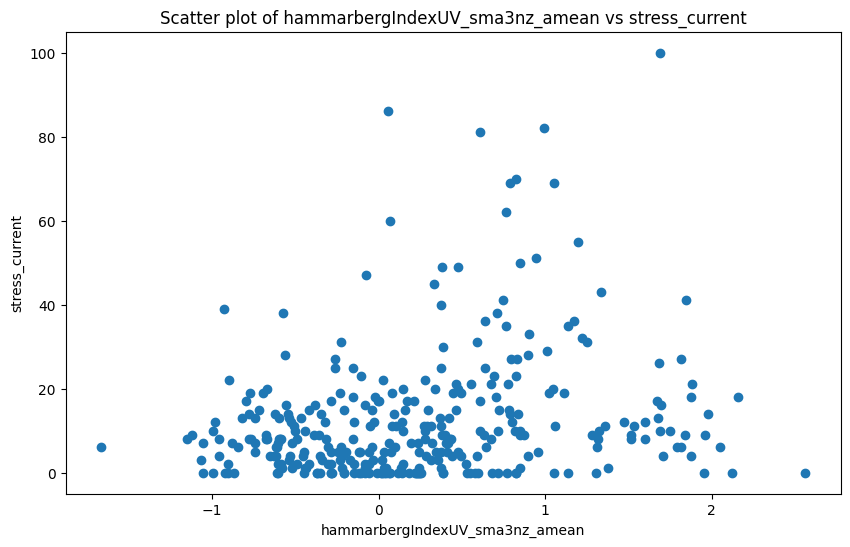

In [29]:
feature = "hammarbergIndexUV_sma3nz_amean"
prompt = "work_tasks_4718"
x_range = None
plot_scatter(
    df_files_train,
    df_features_train,
    feature,
    target="stress_current",
    prompt=prompt,
    x_range=x_range,
)

Emotion acting 5839 - Nilago neutral: slopeV0500_sma3nz_stddevNorm (SC: -0.329743623110104, p-value: 0.00000000148979434180412, FDR-BH: 0.000000131101902078763)

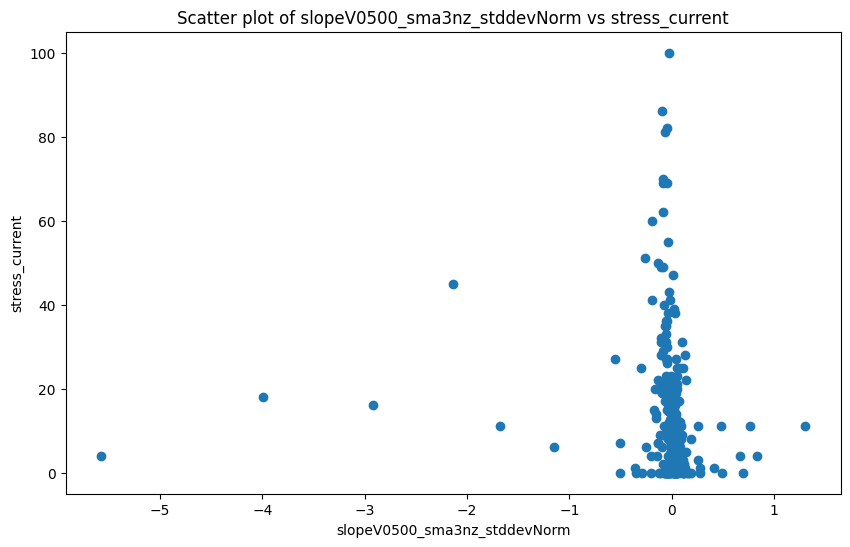

In [30]:
feature = "slopeV0500_sma3nz_stddevNorm"
prompt = "emotion_acting_5839"
x_range = None
plot_scatter(
    df_files_train,
    df_features_train,
    feature,
    target="stress_current",
    prompt=prompt,
    x_range=x_range,
)

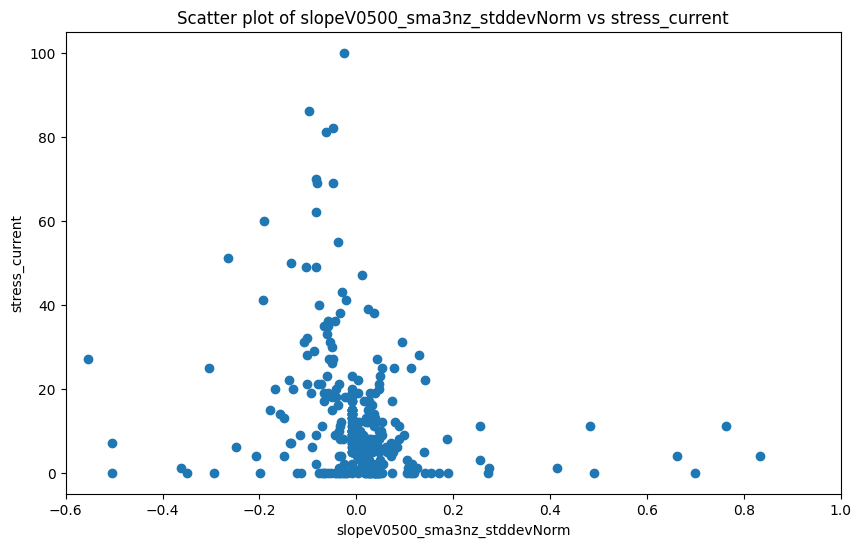

In [31]:
feature = "slopeV0500_sma3nz_stddevNorm"
prompt = "emotion_acting_5839"
x_range = [-0.6, 1]
plot_scatter(
    df_files_train,
    df_features_train,
    feature,
    target="stress_current",
    prompt=prompt,
    x_range=x_range,
)

Emotion acting 4373 - Nilago happy: slopeV0500_sma3nz_stddevNorm (SC: -0.343141347432087, p-value: 0.000000000284881998189291, FDR-BH: 0.0000000250696158406576)

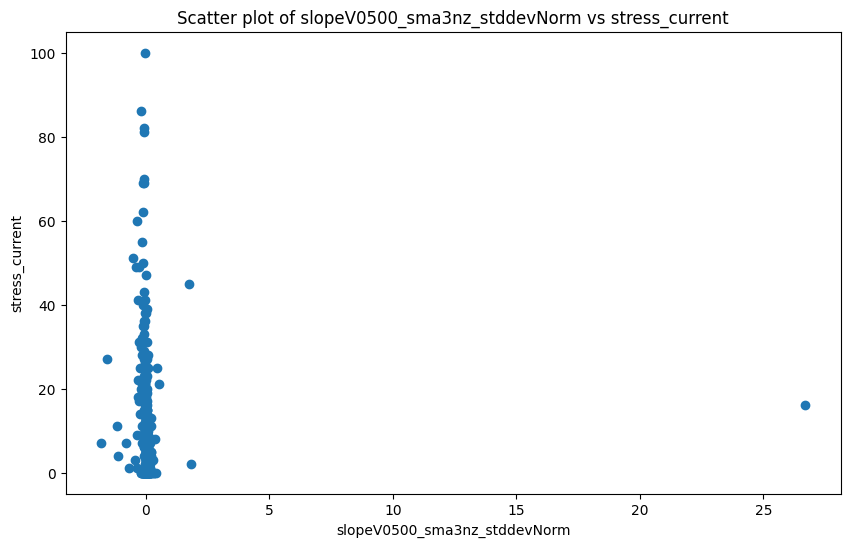

In [32]:
feature = "slopeV0500_sma3nz_stddevNorm"
prompt = "emotion_acting_4373"
x_range = None
plot_scatter(
    df_files_train,
    df_features_train,
    feature,
    target="stress_current",
    prompt=prompt,
    x_range=x_range,
)

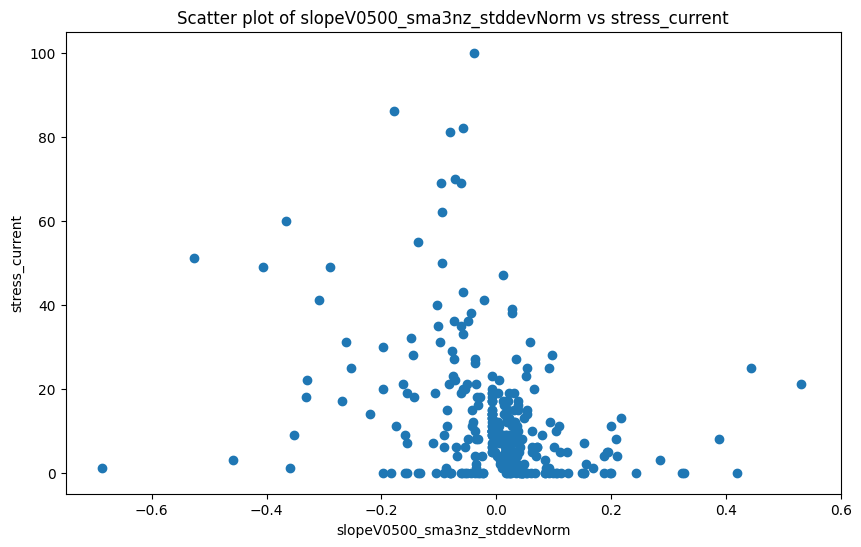

In [33]:
feature = "slopeV0500_sma3nz_stddevNorm"
prompt = "emotion_acting_4373"
x_range = [-0.75, 0.6]
plot_scatter(
    df_files_train,
    df_features_train,
    feature,
    target="stress_current",
    prompt=prompt,
    x_range=x_range,
)

Emotion acting 4373 - Nilago happy: F1frequency_sma3nz_amean (SC: -0.309347911129469, p-value: 0.0000000159194439420355, FDR-BH: 0.000000700455533449563)

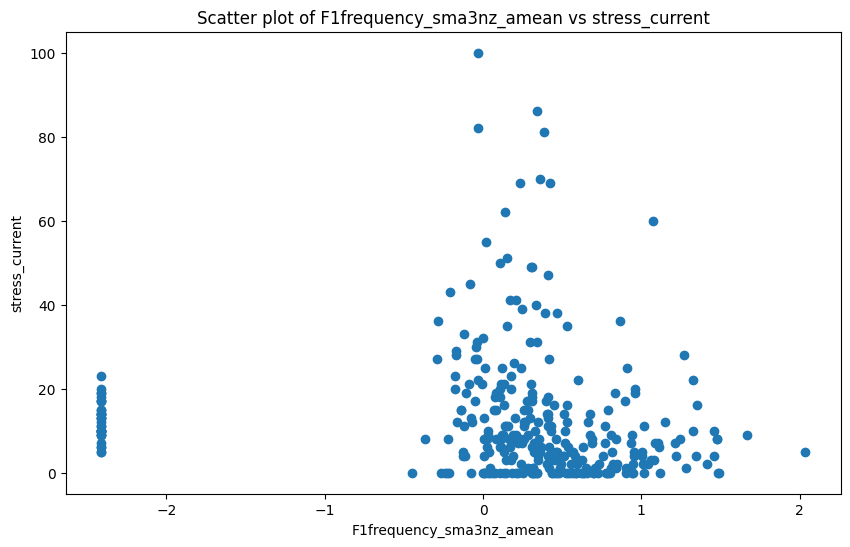

In [34]:
feature = "F1frequency_sma3nz_amean"
prompt = "emotion_acting_4373"
x_range = None
plot_scatter(
    df_files_train,
    df_features_train,
    feature,
    target="stress_current",
    prompt=prompt,
    x_range=x_range,
)

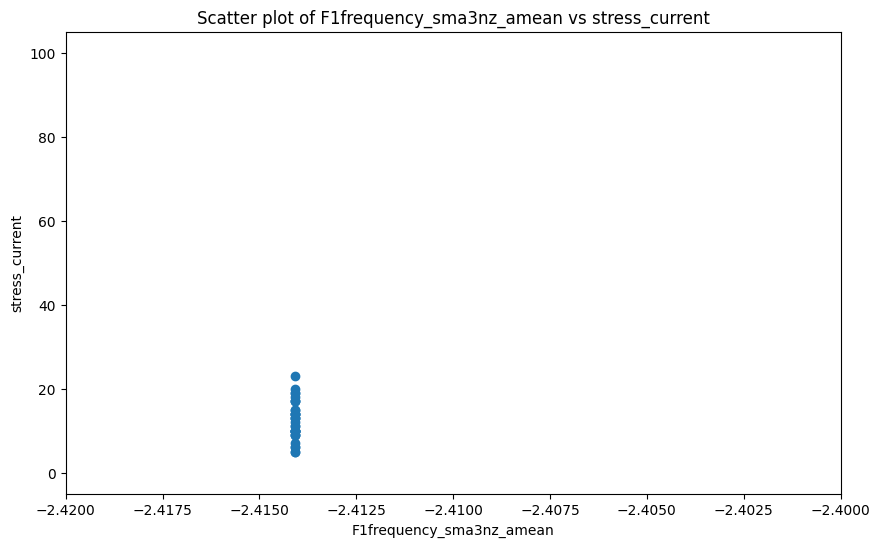

In [35]:
# Downloaded and re-named to save as separate file from other range plot
feature = "F1frequency_sma3nz_amean"
prompt = "emotion_acting_4373"
x_range = [-2.42, -2.4]
plot_scatter(
    df_files_train,
    df_features_train,
    feature,
    target="stress_current",
    prompt=prompt,
    x_range=x_range,
)

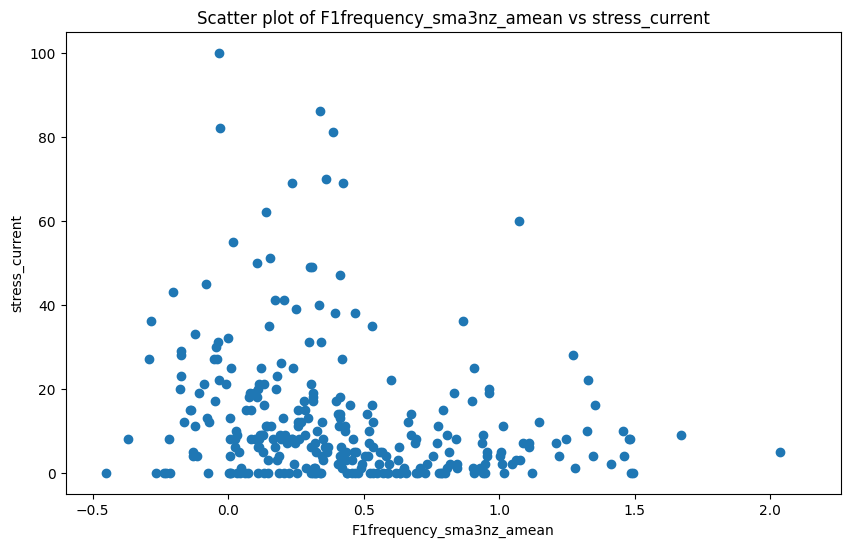

In [36]:
# Downloaded and re-named to save as separate file from other range plot
feature = "F1frequency_sma3nz_amean"
prompt = "emotion_acting_4373"
x_range = [-0.6, None]
plot_scatter(
    df_files_train,
    df_features_train,
    feature,
    target="stress_current",
    prompt=prompt,
    x_range=x_range,
)